In [1]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [2]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[0.50, 1.00],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._simple_square(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [3]:
venus = Venus(jitter=0.01)

set the currents and read the beam value

In [4]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

0.5015235853987722


if currents are outside the range a `ValueError` is raised and can be captured.

In [5]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [7]:
venus._himmelblau4(6, 6, 6)

AttributeError: 'Venus' object has no attribute '_himmelblau4'

# Bayesian Optimization

In [12]:
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=0.05)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  0.5127   |  178.8    |  153.6    |  144.4    |
|  2        |  0.9006   |  182.0    |  151.3    |  141.1    |
|  3        | -0.7943   |  177.0    |  148.9    |  137.6    |
|  4        | -1.06     |  175.7    |  147.8    |  139.4    |
|  5        |  0.651    |  179.8    |  153.7    |  140.3    |
|  6        |  0.6574   |  185.0    |  155.0    |  143.1    |
|  7        | -0.8395   |  185.0    |  155.0    |  135.0    |
|  8        |  0.3811   |  185.0    |  149.3    |  145.0    |
|  9        | -0.8842   |  185.0    |  145.0    |  139.6    |
|  10       |  0.8365   |  182.6    |  152.9    |  145.0    |
|  11       |  0.8172   |  181.7    |  155.0    |  142.5    |
|  12       |  0.9788   |  183.3    |  152.5    |  142.4    |
|  13       |  0.927    |  181.7    |  151.3    |  143.4    |
|  14       | -2.172    |  175.0    |  155.0    |  135.0    |
|  15   

In [8]:
import random
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": (175, 185), "B": (145, 155), "C": (135, 145)}
    noise = max(venus.get_noise_level(), 1e-5)
    print(noise)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.scatter([182.5], [151.7], s=180, marker="*") # , [140.0]
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))    

## Simple Trial

0.005


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

Best result: {'A': 182.6452822704883, 'B': 152.7173097070819, 'C': 142.51102355797215}; f(x) = 1.0015015397917804.


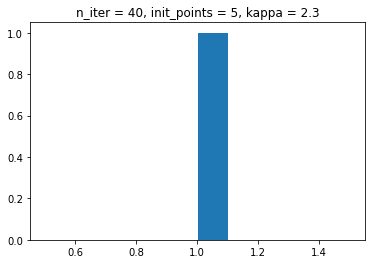

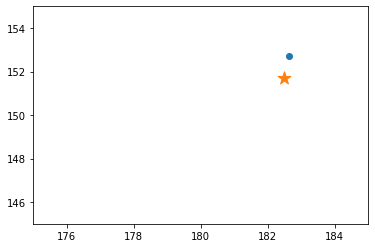

[1.0015015397917804]


In [9]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

0.005


100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


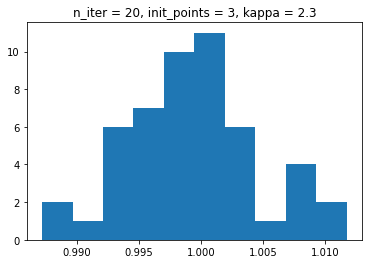

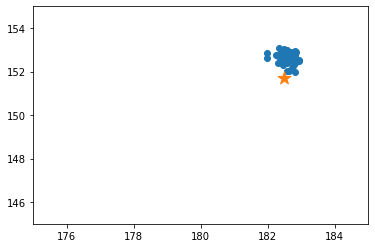

[1.0117295544515272, 1.0113013305830991, 1.0091194278020452, 1.0072175715773781, 1.0071667163173394, 1.006920481936522, 1.0061856390118042, 1.004119963247976, 1.003842068282026, 1.0036584845436143, 1.003279975942905, 1.0032276530771607, 1.0025365316802843, 1.0018768972418224, 1.0018373482129035, 1.0018146768814369, 1.0004498632901446, 1.000318445431335, 1.0001667786534976, 0.9998712819580633, 0.9997729479992354, 0.999558756250063, 0.9995471582349027, 0.9995277507736229, 0.998786563749335, 0.9987705910399216, 0.9987547972591657, 0.9985640415117183, 0.9983858934285905, 0.9982226934492422, 0.9974001067829115, 0.9972939842955858, 0.9971181700388796, 0.9970902440098597, 0.9969467228587261, 0.9967615506520906, 0.996470633962278, 0.9960966183458413, 0.9957684566963282, 0.9954732842203515, 0.9949417602676753, 0.9944707025877197, 0.9944185927415496, 0.9942101288878173, 0.9938799243914702, 0.9937023799501742, 0.9927455378620348, 0.9906787545255374, 0.9873953670291828, 0.9871869673375089]


In [10]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

0.005


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


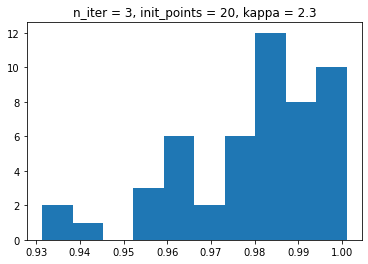

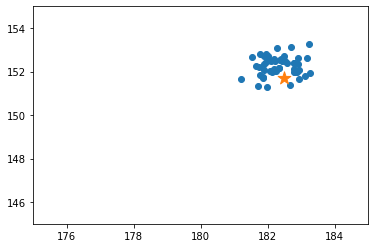

[1.0010482446101505, 1.0006288788674755, 1.0004616583268513, 0.9996725869843796, 0.9994851411304313, 0.9993461301963975, 0.9975947392839599, 0.996989365112215, 0.9964246836082391, 0.9940971242530908, 0.9928032800040605, 0.9926603391412123, 0.9925295074478961, 0.9907381855075774, 0.9906355100575226, 0.989812605646109, 0.9890029042392092, 0.9889924900517971, 0.9863361618310778, 0.9862032778611426, 0.9858760760036558, 0.985718825490246, 0.9856734514188099, 0.9851170353351635, 0.984247847379135, 0.9831859012480013, 0.9825934761051274, 0.981700420544579, 0.9811789632075464, 0.9811158068307899, 0.979519175830281, 0.9794389305718856, 0.9789847414711855, 0.9781030563745752, 0.9760173780059349, 0.9734174122632546, 0.9723712024706233, 0.9687522412750175, 0.9660441515653819, 0.9658019418723196, 0.9633229727804431, 0.96231206690679, 0.9613452933140639, 0.959760522740293, 0.9578120425229215, 0.9577036787853571, 0.9566696091505151, 0.9404724656730563, 0.9368374748476158, 0.9313560242858268]


In [11]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)

## Trying out kappa

0.005


100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


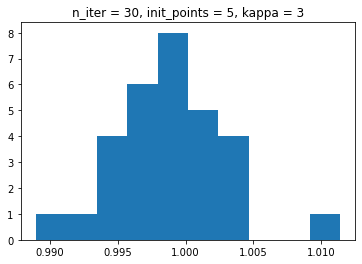

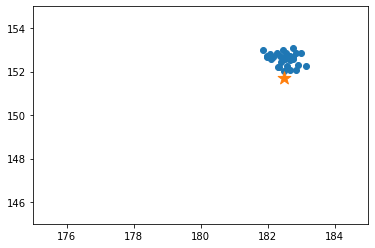

[1.0114121185698495, 1.004248557903531, 1.0038765821051132, 1.0031336632570853, 1.0025930926903301, 1.0021602017864786, 1.0012882707768906, 1.001065891887599, 1.0010472742651466, 1.0007814643218844, 1.0001293615053028, 0.9990575936295057, 0.9988913153013759, 0.9988741276872956, 0.9986315020066636, 0.9983871129764934, 0.9982537159529652, 0.9980592857450373, 0.997526029301099, 0.9973138130668905, 0.9971401070190651, 0.9971062094908139, 0.9970339126411092, 0.9965760266471149, 0.9956773399529154, 0.9945620711467771, 0.9941131269257723, 0.9934729397477645, 0.9922651641949961, 0.9889362174819715]


In [12]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1)

0.005


100%|██████████| 30/30 [01:19<00:00,  2.66s/it]


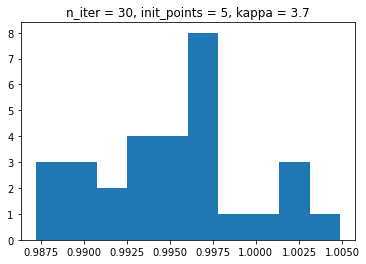

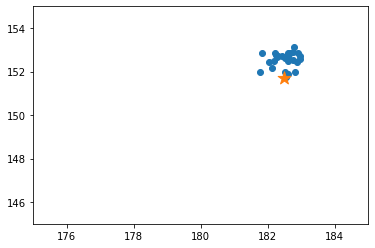

[1.0048881646865797, 1.0029922554975044, 1.002873860222596, 1.0024369627578635, 0.9997431317830359, 0.9979577961173987, 0.9976460000838467, 0.9970980897442528, 0.9966644422433568, 0.9964769997390998, 0.9963899888817562, 0.9962824234455303, 0.9961704762542318, 0.9961594186087929, 0.9957680521354644, 0.9957618528513761, 0.9951701125653314, 0.9944797416424207, 0.993933044866266, 0.993700777739297, 0.9935297748342495, 0.9928585399277895, 0.9921776427817336, 0.9911078484436912, 0.9900340211894118, 0.9896754285174247, 0.9894341519419355, 0.9889337573413997, 0.9884356888697733, 0.9872266918778518]


In [13]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1)

0.005


100%|██████████| 30/30 [01:20<00:00,  2.69s/it]


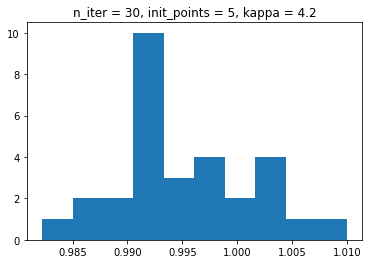

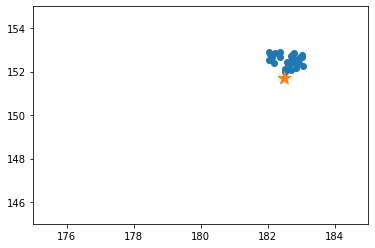

[1.0099275651075061, 1.0057432407079239, 1.0031714074141276, 1.0028285787529923, 1.0026152207791652, 1.0016914624359692, 1.00031013983553, 0.9996494411183863, 0.9986770665152287, 0.9969277307566085, 0.9968141596813636, 0.996336737903061, 0.9957287682640532, 0.9941436079836427, 0.9938991442101162, 0.9927801253840202, 0.9925087780288895, 0.9924450274435312, 0.9918306154596769, 0.9914860220989694, 0.991344979220506, 0.9913035019404713, 0.9911666277669351, 0.9911577838235325, 0.9911365890342339, 0.9900532272172319, 0.9889288623218873, 0.9877587255908526, 0.9871933822065762, 0.9822398620051983]


In [14]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [01:20<00:00,  2.70s/it]


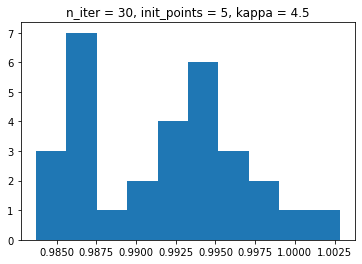

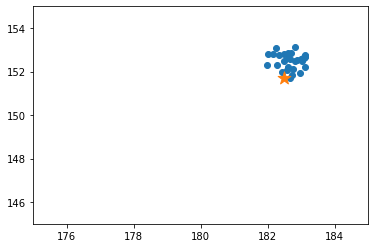

[1.002845496143244, 1.0003652682912207, 0.9981181859399981, 0.9977148677181087, 0.9967170052211959, 0.996322724474511, 0.9958723311851332, 0.9949221158611086, 0.994517539938718, 0.9945106246821662, 0.9944773642023491, 0.994319408487423, 0.9935273096349966, 0.9929989724649634, 0.9928331850304872, 0.9919169689871172, 0.9916141091588606, 0.9910507490832554, 0.9895429729944599, 0.9880299252317568, 0.9875220095190874, 0.9874742181975683, 0.9874377617748518, 0.9874251784310906, 0.9872578224555574, 0.9869105420069908, 0.9856624764225662, 0.9853672303131711, 0.9837846092369049, 0.983694691880906]


In [15]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1)

## Increase n_iter

0.005


100%|██████████| 30/30 [04:09<00:00,  8.33s/it]


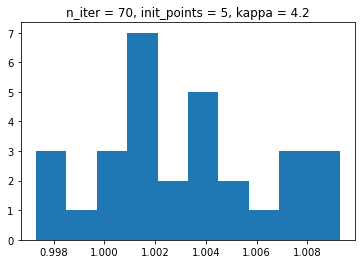

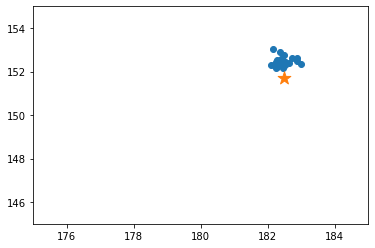

[1.009293574262792, 1.00854108503846, 1.0081116780782353, 1.0073653585771458, 1.007308336493777, 1.0070796605675907, 1.0065207769763043, 1.0056238980182735, 1.005160058478698, 1.0044496722805714, 1.003857308497389, 1.0038032306274174, 1.0037887226217377, 1.0036328893939248, 1.0029714977042912, 1.0025183811028833, 1.0020936628954877, 1.001932230316866, 1.001930790520646, 1.001800519640485, 1.0014782367575785, 1.0014444229217077, 1.0013938859080505, 1.000831254078408, 1.0006156686199872, 1.0004218900180861, 0.9988406972230829, 0.9982766537864265, 0.9980892407415828, 0.9972994642454442]


In [16]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [04:13<00:00,  8.45s/it]


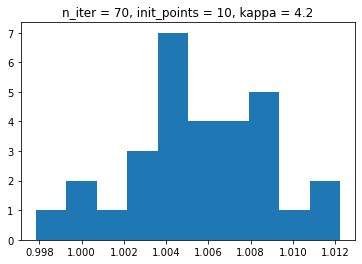

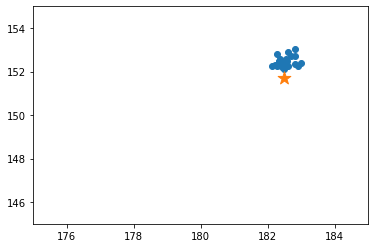

[1.0122385549118398, 1.0119465915401302, 1.0096966977720352, 1.008905075508967, 1.0088612013902272, 1.0086397049951552, 1.008136002043193, 1.0079193250155458, 1.007351400303183, 1.0072418881836172, 1.0071621294723168, 1.006529488897017, 1.0063399710984506, 1.006226174675893, 1.0055827571396603, 1.005454739684882, 1.0048662279793787, 1.0046184231942212, 1.0039759710297589, 1.0039423711758202, 1.0038993993608298, 1.0038227961776012, 1.0036740468306666, 1.0033662431549166, 1.0033395703268706, 1.0023953392763503, 1.0008931232611986, 1.0005222128422517, 0.9994321917441673, 0.997825126119587]


In [17]:
trial(30, n_iter = 70, init_points = 10, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [17:21<00:00, 34.72s/it] 


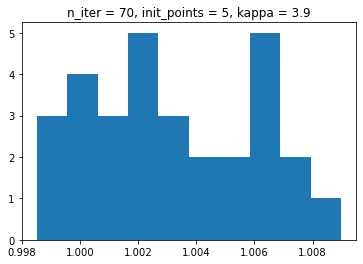

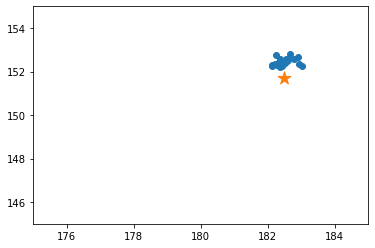

[1.0089826652165388, 1.0078269633320995, 1.0070100890310352, 1.006813438290966, 1.00680001035499, 1.0066894756569846, 1.0065500675557248, 1.006224694779767, 1.00554872500367, 1.005107788502952, 1.004457127507752, 1.0044389330426935, 1.0034164868202742, 1.0033953130713134, 1.003304547654519, 1.00256644312149, 1.0019328937303102, 1.0018770691073249, 1.0018555230482664, 1.0018442233188143, 1.001165400863245, 1.0010130942226194, 1.0007535976824706, 1.0004242367609768, 1.0003104977998893, 1.0000285063205705, 1.0000100989492129, 0.9994977384362354, 0.9988042698896549, 0.9985207799495563]


In [18]:
trial(30, n_iter = 70, init_points = 5, kappa = 3.9, verbose = 1)

# Try to decrease n_iter but do more trials. Fix kappa at 4.2

0.005


100%|██████████| 100/100 [16:15<00:00,  9.75s/it] 


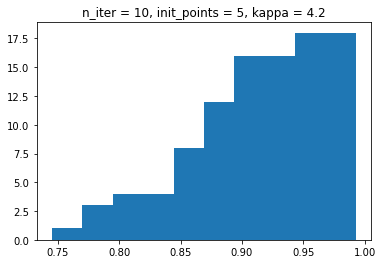

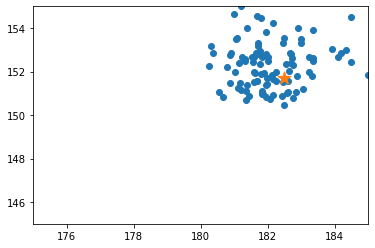

[0.9929722327915513, 0.9914993567628649, 0.9874754744072455, 0.9818312879942486, 0.9818032836564299, 0.9803936209937869, 0.9803545539936919, 0.9797571643773713, 0.9779856145629825, 0.9757335097450743, 0.9750621224342969, 0.9738929093604025, 0.9727706063578827, 0.9721919190870681, 0.9702713722826675, 0.9698364159627699, 0.9692075189543565, 0.9685272952777073, 0.9652060827910705, 0.9620969434551981, 0.9617717350735955, 0.9609786540867589, 0.9609160449711152, 0.9592278339378619, 0.9590209962861906, 0.9573243018088926, 0.957099390144514, 0.9547158626635077, 0.9545591730931141, 0.9536528756492069, 0.9533278341841079, 0.9513027318265548, 0.9504245706641448, 0.9494252806262522, 0.9492971134217422, 0.9478867524979436, 0.9407688150723967, 0.9404876862359139, 0.936343301825107, 0.9359041917796045, 0.9337057658851066, 0.9301692095607816, 0.9299600874180243, 0.9293691956384822, 0.9286818701266015, 0.9273732711102151, 0.9268433064210522, 0.9263461568486779, 0.9224224440988753, 0.9221517724341541, 0

In [19]:
trial(100, n_iter = 10, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 100/100 [49:21<00:00, 29.62s/it]  


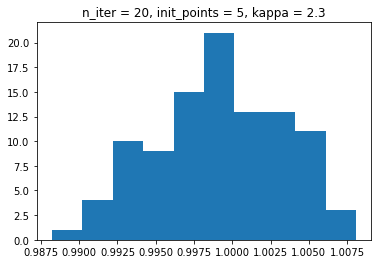

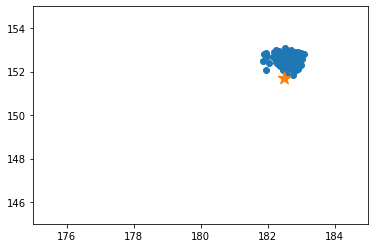

[1.0080909546510033, 1.0070153289602672, 1.00622651705912, 1.005699744770563, 1.0055357896397807, 1.005304494410228, 1.0052078195920826, 1.0051946226098187, 1.0049649310761979, 1.0048042373471815, 1.0046745883230148, 1.0045433451903238, 1.0043106405240785, 1.0041289800764366, 1.003640466107231, 1.0034783601072914, 1.0031536713974583, 1.0030506667577161, 1.0030455619968348, 1.002970425691048, 1.00296805966387, 1.002814611257397, 1.002689404496814, 1.0025248845105201, 1.0025152523478025, 1.0025057719472834, 1.002144844839386, 1.0020477639076404, 1.0020260214983079, 1.0020036217368604, 1.001889940427339, 1.0016182104443832, 1.00144246064671, 1.0014331450392675, 1.0012851606220674, 1.0012786654877628, 1.0008296505028595, 1.0006674108662466, 1.0004948220496042, 1.0001907970886896, 1.0000381741148683, 0.9997487917414005, 0.9996875550796518, 0.9996306847425719, 0.9994844039956924, 0.9993922807341254, 0.9992485712615449, 0.9990946198056755, 0.9990683150280854, 0.9989366129544824, 0.99881863114

In [20]:
trial(100, n_iter = 20, init_points = 5, kappa = 2.3, verbose = 1)

0.005


100%|██████████| 100/100 [1:01:22<00:00, 36.83s/it]


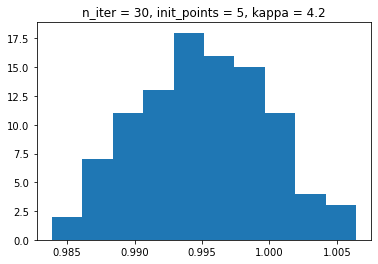

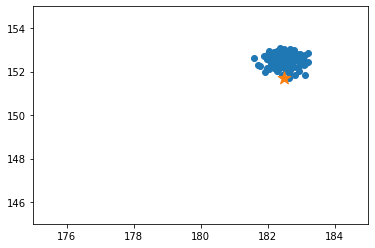

[1.006434459358759, 1.005537595176266, 1.0050746533452992, 1.003788011260399, 1.003160182804496, 1.0025953046127496, 1.0021115551973916, 1.001798893174795, 1.0017656962615422, 1.0016992357869494, 1.0011535991702631, 1.0008921403293565, 1.0007593815618487, 1.000227083380669, 1.0000874063081016, 0.9999476339087682, 0.9998735160924646, 0.9997826040664639, 0.9996360891665744, 0.9995908162250728, 0.9991285461613233, 0.9987778214172848, 0.9987418695317455, 0.9986030678186482, 0.9984196847560289, 0.9982555888087598, 0.9982481563567625, 0.9981292648193024, 0.9981186938596698, 0.9978188564827901, 0.997808859996711, 0.9978050005996693, 0.9977458644268049, 0.9973811431331477, 0.9973708363812048, 0.997217008408601, 0.9970129978819287, 0.996895800696667, 0.9968668807253371, 0.9968402510440484, 0.9968329013131598, 0.9967110402597659, 0.996643590755654, 0.9961947351519003, 0.9960774558036163, 0.9958150485569617, 0.9957777646490997, 0.995731156740502, 0.9955674105542153, 0.9946011669177659, 0.99459342

In [21]:
trial(100, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 100/100 [1:38:15<00:00, 58.95s/it]  


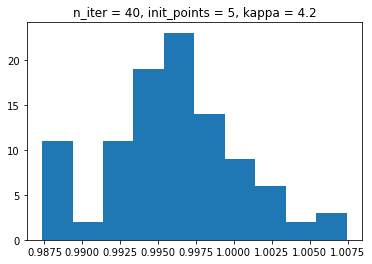

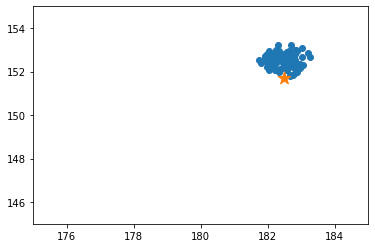

[1.0074335796649376, 1.0066761965774793, 1.005442455007923, 1.0045916192817286, 1.0036223397017885, 1.003280400213643, 1.0031280370491062, 1.0028029457416143, 1.002396541453467, 1.001773966023372, 1.0016015816553456, 1.0008708892900864, 1.0007697870725498, 1.0007334225694222, 1.0004587921055197, 1.0004359202135573, 1.0003281820242629, 0.9999351288125151, 0.9998532463783529, 0.9997712705971518, 0.9993754275046787, 0.9993674803456585, 0.9992587969913796, 0.9990428966361248, 0.9988979007502891, 0.9986098739323124, 0.9982167387081532, 0.9981641287402772, 0.998157040898865, 0.998053668331953, 0.99784090922202, 0.9977803353015677, 0.9974960888222992, 0.9974724650240281, 0.9973325212142988, 0.9972865087932961, 0.9972382732679044, 0.9971395391273858, 0.9970732201440959, 0.996943755440618, 0.9968912702812438, 0.996883200374368, 0.9967745517539978, 0.9964531299992194, 0.9963006549736956, 0.9962766133433174, 0.996247080280264, 0.9961872852428211, 0.9961053734949346, 0.9960923595328742, 0.99604599

In [22]:
trial(100, n_iter = 40, init_points = 5, kappa = 4.2, verbose = 1)

# Best parameters: kappa = 4.2, n_iter = 40

In [23]:
# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}

def venus_opt(venus:Venus):
    venus.
venus_opt(1)

SyntaxError: invalid syntax (<ipython-input-23-379e0b5c32fa>, line 11)

In [ ]:
# TODO: guide optimization to known good points
# TODO: modify the loss function to have larger differences between global min and local min
# TODO: find a way to set halting condition or use a different library

In [ ]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [ ]:
# ackley_arg0((0,0,0))

In [ ]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2